# Melt Pond Depth Algorithm Comparison, Amery Ice Shelf

In [1]:
%matplotlib notebook
import copy
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import pickle as pkl
from os import listdir, makedirs
from os.path import isfile, join, exists
from scipy.io import loadmat
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

## get photon data 
The pickle file is generated from granules using the **processATL03data** notebook.

In [2]:
fn_IS2 = 'data/amery_ponds_icesat2_data.pkl'
with open(fn_IS2, 'rb') as handle:
    is2data = pkl.load(handle)
ponds = list(is2data)

## get manual picking data 
The pickle file is generated from manually picked data using the **manualPondPickingResults** notebook.

In [3]:
fn_picking = 'data/amery_ponds_manual_picking_data.pkl'
with open(fn_picking, 'rb') as handle:
    pickingData = pkl.load(handle)
for i,pond in enumerate(is2data):
    p = is2data[pond]
    p['picking'] = pickingData[pond]
    p['lat_intp'] = p['picking']['lat_interp']
    p['df_int'] = pd.DataFrame(index=p['lat_intp'],data=p['picking']['depth_mid2quartile_mean'],columns=['manual'])

## get algorithms data
### Datta

In [4]:
person = 'datta'
keys = ['lat','lon','h_ph','conf_ph','surf','bott','depth','depth_corr','depth_icelayer','depth_corr_icelayer',
        'surf_icelayer','h_icelayer']
for i,pond in enumerate(is2data):
    fn = 'data/' + person + '/amery_finV-' + pond+'.csv'
    df = pd.read_csv(fn,names=keys)
    df.sort_values(by='lat',inplace=True)
    is2data[pond][person] = {k:np.array(df.iloc[:,i]) for i,k in enumerate(keys)}
    p = is2data[pond]
    p[person]['depth_intp'] = np.interp(p['lat_intp'], p[person]['lat'], p[person]['depth_icelayer'], left=np.nan, right=np.nan)
    p['df_int'][person] = p[person]['depth_intp']

### Fair/Flanner

In [5]:
person = 'fair_flanner'
keys = ['lat','lon','depth']
for i,pond in enumerate(is2data):
    fn = 'data/' + person + '/' + pond+'.txt'
    df = pd.read_csv(fn,names=keys)
    df.sort_values(by='lat',inplace=True)
    p = is2data[pond]
    p[person] = {k:np.array(df.iloc[:,i]) for i,k in enumerate(keys)}
    p[person]['depth_intp'] = np.interp(p['lat_intp'], p[person]['lat'], p[person]['depth'], left=np.nan, right=np.nan)
    p['df_int'][person] = p[person]['depth_intp']

### Herzfeld
(withdrew from paper, so don't plot later)

In [6]:
person = 'herzfeld'
keys = ['id','x_atc','lat','lon','bott','depth']
for i,pond in enumerate(is2data):
    fn = 'data/' + person + '/' + pond+'.dat'
    df = pd.read_csv(fn,names=keys,sep=' ')
    df.sort_values(by='lat',inplace=True)
    p = is2data[pond]
    p[person] = {k:np.array(df.iloc[:,i]) for i,k in enumerate(keys)}
    p[person]['depth_intp'] = np.interp(p['lat_intp'], p[person]['lat'], p[person]['depth'], left=np.nan, right=np.nan)
    p['df_int'][person] = p[person]['depth_intp']

### Jasinski

In [7]:
person = 'jasinski'
keys = ['time','ATL13meltWGS84','lat','lon','depth']
for i,pond in enumerate(is2data):
    fn = 'data/' + person + '/' + pond+'.csv'
    df = pd.read_csv(fn,names=keys,sep=',',header=0)
    df['lat'] = df.lat.interpolate()
    df.sort_values(by='lat',inplace=True)
    p = is2data[pond]
    p[person] = {k:np.array(df.iloc[:,i]) for i,k in enumerate(keys)}
    p[person]['depth_intp'] = np.interp(p['lat_intp'], p[person]['lat'], p[person]['depth'], left=np.nan, right=np.nan)
    p['df_int'][person] = p[person]['depth_intp']

### Magruder
(need to average photon depths here)

In [8]:
person = 'magruder'
keys = ['lat','bott','bott_corr','surf','depth','depth_corr', 'corr_percent']
stepsz = 0.00001
for i,pond in enumerate(is2data):
    fn = 'data/' + person + '/' + pond+'.csv'
    df = pd.read_csv(fn,names=keys,header=0)
    df.sort_values(by='lat',inplace=True)
    p = is2data[pond]
    p[person] = {k:np.array(df.iloc[:,i]) for i,k in enumerate(keys)}
    avglats = np.arange(start=p['latlims'][0],stop=p['latlims'][1],step=stepsz)
    wid = (avglats[1] - avglats[0]) / 2
    midl = avglats[:-1] + wid
    middepths = np.full_like(midl,fill_value=np.nan)
    w = 30
    for j in range(len(midl)):
        inrange = (p[person]['lat'] > (midl[j]-w*wid)) & (p[person]['lat'] <= (midl[j]+w*wid))
        middepths[j] = np.nanmean((p[person]['depth'])[inrange])
    middepths[np.isnan(middepths)] = 0;
    p[person]['lat_old'] = p[person]['lat']
    p[person]['depth_old'] = p[person]['depth']
    p[person]['lat'] = midl
    p[person]['depth'] = middepths
    p[person]['depth_intp'] = np.interp(p['lat_intp'], p[person]['lat'], p[person]['depth'], left=np.nan, right=np.nan)
    p[person]['depth_intp'][p['picking']['depth_mid2quartile_mean']==0] = 0
    p['df_int'][person] = p[person]['depth_intp']

### Moussavi

In [9]:
person = 'moussavi_pope'
fn = 'data/' + person + '/' + 'pondsSentinel2.mat'
matdat = loadmat(fn)
for i,pond in enumerate(is2data):
    p = is2data[pond]
    theselats = matdat['latspope']
    thesedepths = matdat['depthpope'] / 1e3
    inpond = (theselats > p['latlims'][0]) & (theselats < p['latlims'][1])
    theselats = theselats[inpond]
    thesedepths = thesedepths[inpond]
    keys = ['lat', 'depth']
    df = pd.DataFrame(data=list(zip(theselats, thesedepths)),columns=keys)
    df.sort_values(by='lat',inplace=True)
    p[person] = {k:np.array(df.iloc[:,i]) for i,k in enumerate(keys)}
    p[person]['depth_intp'] = np.interp(p['lat_intp'], p[person]['lat'], p[person]['depth'], left=np.nan, right=np.nan)
    p['df_int'][person] = p[person]['depth_intp']

### Spergel

In [10]:
person = 'spergel_kingslake'
for i,pond in enumerate(is2data):
    if i < 3:
        keys = ['id','depth','lat','lon']
    else:
        keys = ['id','depth','lat','zeros','lon']  # weird column of zeros in here
    fn = 'data/' + person + '/' + pond+'.txt'
    df = pd.read_csv(fn,names=keys,header=0)
    df.sort_values(by='lat',inplace=True)
    df.depth = df.depth / 1000.0  # make meters
    p = is2data[pond]
    p[person] = {k:np.array(df.iloc[:,i]) for i,k in enumerate(keys)}
    p[person]['depth_intp'] = np.interp(p['lat_intp'], p[person]['lat'], p[person]['depth'], left=np.nan, right=np.nan)
    p['df_int'][person] = p[person]['depth_intp']

### Arndt

In [11]:
person = 'arndt'
fn_arndt = 'data/arndt/pondsRDBmovmean.pkl'
with open(fn_arndt, 'rb') as handle:
    arndt_data = pkl.load(handle)
for i,pond in enumerate(is2data):
    df = arndt_data[i]
    df.sort_values(by='lat',inplace=True)
    df.depth = np.abs(df.depth)
    p = is2data[pond]
    keys = list(df.columns)
    p[person] = {k:np.array(df.iloc[:,i]) for i,k in enumerate(keys)}
    p[person]['depth_intp'] = np.interp(p['lat_intp'], p[person]['lat'], p[person]['depth'], left=np.nan, right=np.nan)
    p['df_int'][person] = p[person]['depth_intp']

## get median estimate from ICESat-2 algorithms

In [12]:
for i,pond in enumerate(is2data):
    p = is2data[pond]
    df = p['df_int']
    df_is = df[['datta','fair_flanner','herzfeld','magruder','jasinski','arndt']].copy()
    for col in df_is.columns:
        df_is[col][(df.manual == 0) & np.isnan(df_is[col])] = 0  # make zero wherever no data, but manual estimate has no pond
    med = df_is.apply(np.nanmedian,axis='columns')
    med = med.rolling(window=20,center=True).mean()
    df['med_algorithms'] = med

## write all data to pickle file

In [13]:
dfs = []
for i,pond in enumerate(is2data):
    df = is2data[pond]['df_int']
    df['pond'] = i+1
    dfs.append(df)
df_out = pd.concat(dfs)
is2data['depth_all_df'] = df_out
df_out.to_csv('data/allCompiledDepthData.csv')
filename_out = 'data/allCompiledData.pkl'
with open(filename_out, 'wb') as handle:
    pkl.dump(is2data, handle, protocol=pkl.HIGHEST_PROTOCOL)

## check the data on a rough plot

<IPython.core.display.Javascript object>


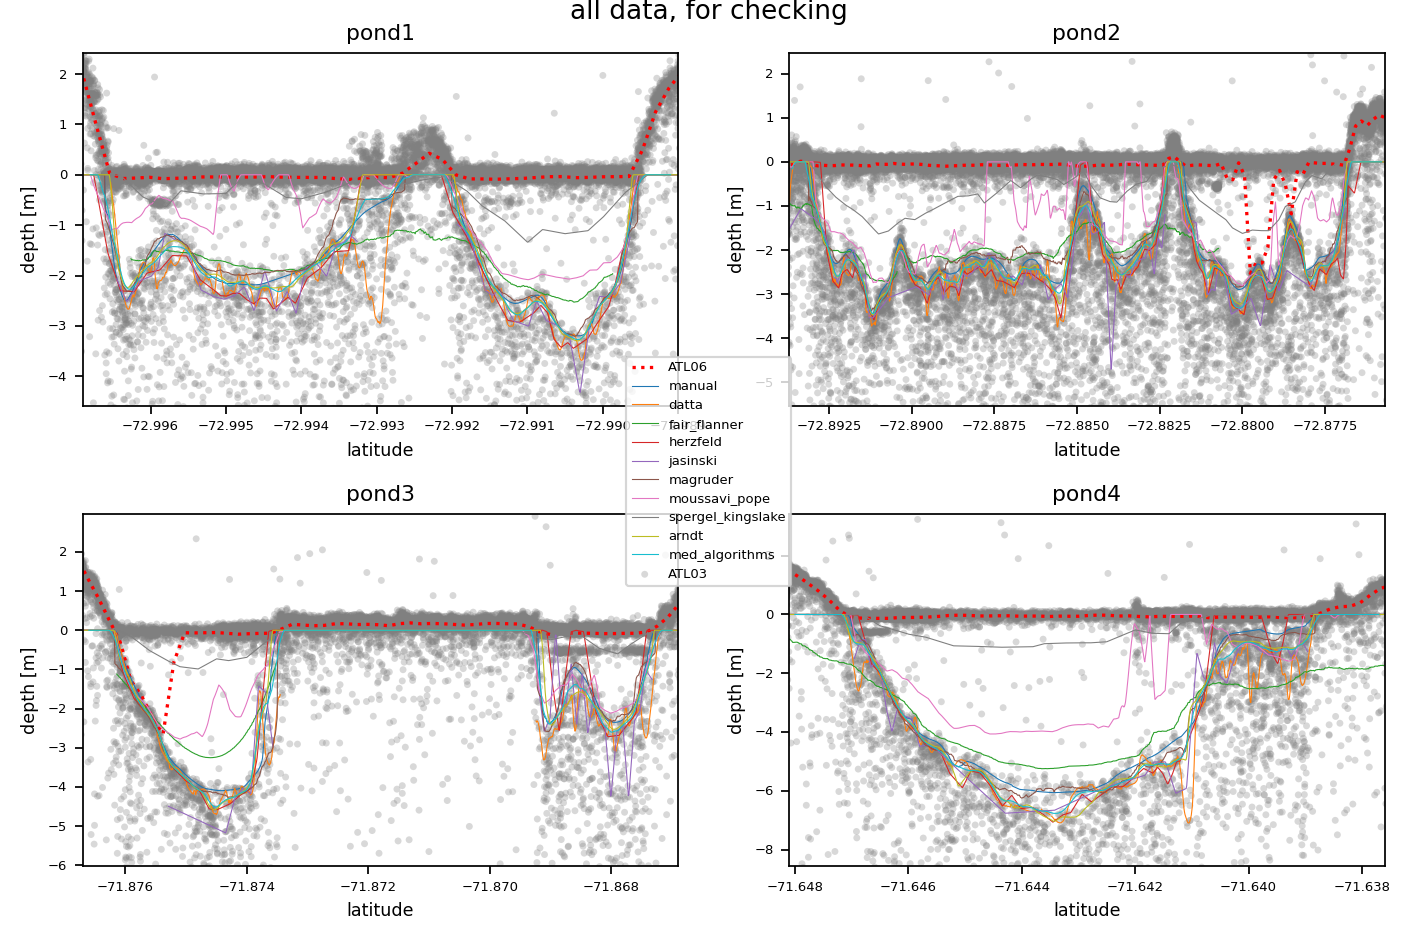

In [14]:
with open('data/allCompiledData.pkl', 'rb') as handle:
    is2data = pkl.load(handle)
ponds = list(is2data)[:-1]
dfdepth = is2data['depth_all_df']
fig = plt.figure(figsize=[9, 6])
for i,pond in enumerate(ponds):
    ax = fig.add_subplot(2,2,i+1)
    p = is2data[pond]
    surf_h = p['picking']['median_surf_height']
    h_atl03 = ax.scatter(p['atl03_lat'], p['atl03_h']-surf_h, s=10, c=[[0.5,0.5,0.5]], 
                         alpha=0.3, edgecolors='none',label='ATL03')
    h_atl06, = ax.plot(p['atl06_lat'], p['atl06_h']-surf_h,'r:',label='ATL06')
    df = dfdepth[dfdepth.pond.eq(i+1)]
    for j in list(df.columns)[:-1]:
        ax.plot(-df[j],lw=0.5,label=j)
    ax.set_title(pond, size=10)
    ax.set_xlabel('latitude', size=8)
    ax.set_ylabel('depth [m]', size=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_ylim(np.array(p['ylims_plot'])-surf_h)
    ax.set_xlim(np.array(p['xlims_plot']))
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center',fontsize=6)
fig.suptitle('all data, for checking', fontsize=12,y=1.0)
fig.tight_layout()